In [7]:
#Importamos las librerías que se va a utilziar
# Pandas para la manipulación de datos
import pandas as pd
# Módulo AST (Abstract Syntax Tree) para evaluar expresiones literales de Python
import ast
# Missingno para la visualización de datos faltantes
import missingno as msno
# vaderSentiment para hacer el análisis de sentimiento
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Extracción de los datos

In [8]:
# Se utiliza pd.read_json para leer el archivo steam_games.json. El parámetro lines=True parsea cada línea como un objeto distinto.
games_1=pd.read_json('Datasets/steam_games.json',orient='column',lines=True)

In [9]:
# Se inicializa una lista vacía donde se van a guardar cada línea del JSON despuéa de ser parseada correctamente.
data = []
#Se lee el json user_reviews.json
with open('Datasets/user_reviews.json', 'rt', encoding='utf-8') as file:
    for line in file:
        try:
            # Se utiliza ast.literal_eval para transformar la información contenida en strigns en estructuras de datos utilizables (en este caso en diccionarios).
            json_data = ast.literal_eval(line)
            #Se guardan las líneas transformadas en la lista data
            data.append(json_data)
        except ValueError as e:
            print(f"Error en la línea: {line}")
            continue

#Se transforma la lista data en un dataframe
reviewss_nested = pd.DataFrame(data)
#El dataframe se encuentra anidado con una lista de diccionarios en la columna items. Para solucionar esto, se utiliza el método explode que desanidar las listas de diccionarios.
reviews_explode = reviewss_nested.explode('reviews')  # Replace 'nested_column_name' with your actual column name
#Se utiliza el método json_normalize para desanidar los diccionarios contenidos en 'items'
reviews_unested = pd.json_normalize(reviews_explode['reviews']).reset_index(drop=True)
#Se reinicia el indice
reviews_explode = reviews_explode.reset_index(drop=True)
#Se concatenan los dataframes reviews_unested y reviews_unested para llegar a un dataframe que contiene toda la información.
reviews = pd.concat([reviews_unested, reviews_explode[['user_id']]], axis=1)

In [10]:
# Se inicializa una lista vacía donde se van a guardar cada línea del JSON despuéa de ser parseada correctamente.
data = []
#Se lee el json user_reviews.json
with open('Datasets/users_items.json', 'rt', encoding='utf-8') as file:
    for line in file:
        try:
            # Se utiliza ast.literal_eval para transformar la información contenida en strigns en estructuras de datos utilizables (en este caso en diccionarios).
            json_data = ast.literal_eval(line)
            #Se guardan las líneas transformadas en la lista data
            data.append(json_data)
        except ValueError as e:
            print(f"Error en la línea: {line}")
            continue

#Se transforma la lista data en un dataframe
items_nested = pd.DataFrame(data)
#El dataframe se encuentra anidado con una lista de diccionarios en la columna items. Para solucionar esto, se utiliza el método explode que desanidar las listas de diccionarios.
items_explode = items_nested.explode('items')  # Replace 'nested_column_name' with your actual column name
#Se utiliza el método json_normalize para desanidar los diccionarios contenidos en 'items'
items_unested = pd.json_normalize(items_explode['items']).reset_index(drop=True)
#Se reinicia el indice
items_explode = items_explode.reset_index(drop=True)
#Se concatenan los dataframes reviews_unested y reviews_unested para llegar a un dataframe que contiene toda la información.
items = pd.concat([items_unested, items_explode[['user_id', 'items_count', 'steam_id']]], axis=1)
print (items.head())

  item_id                  item_name  playtime_forever  playtime_2weeks  \
0      10             Counter-Strike               6.0              0.0   
1      20      Team Fortress Classic               0.0              0.0   
2      30              Day of Defeat               7.0              0.0   
3      40         Deathmatch Classic               0.0              0.0   
4      50  Half-Life: Opposing Force               0.0              0.0   

             user_id  items_count           steam_id  
0  76561197970982479          277  76561197970982479  
1  76561197970982479          277  76561197970982479  
2  76561197970982479          277  76561197970982479  
3  76561197970982479          277  76561197970982479  
4  76561197970982479          277  76561197970982479  


Transformación y EDA básico

Games

<Axes: >

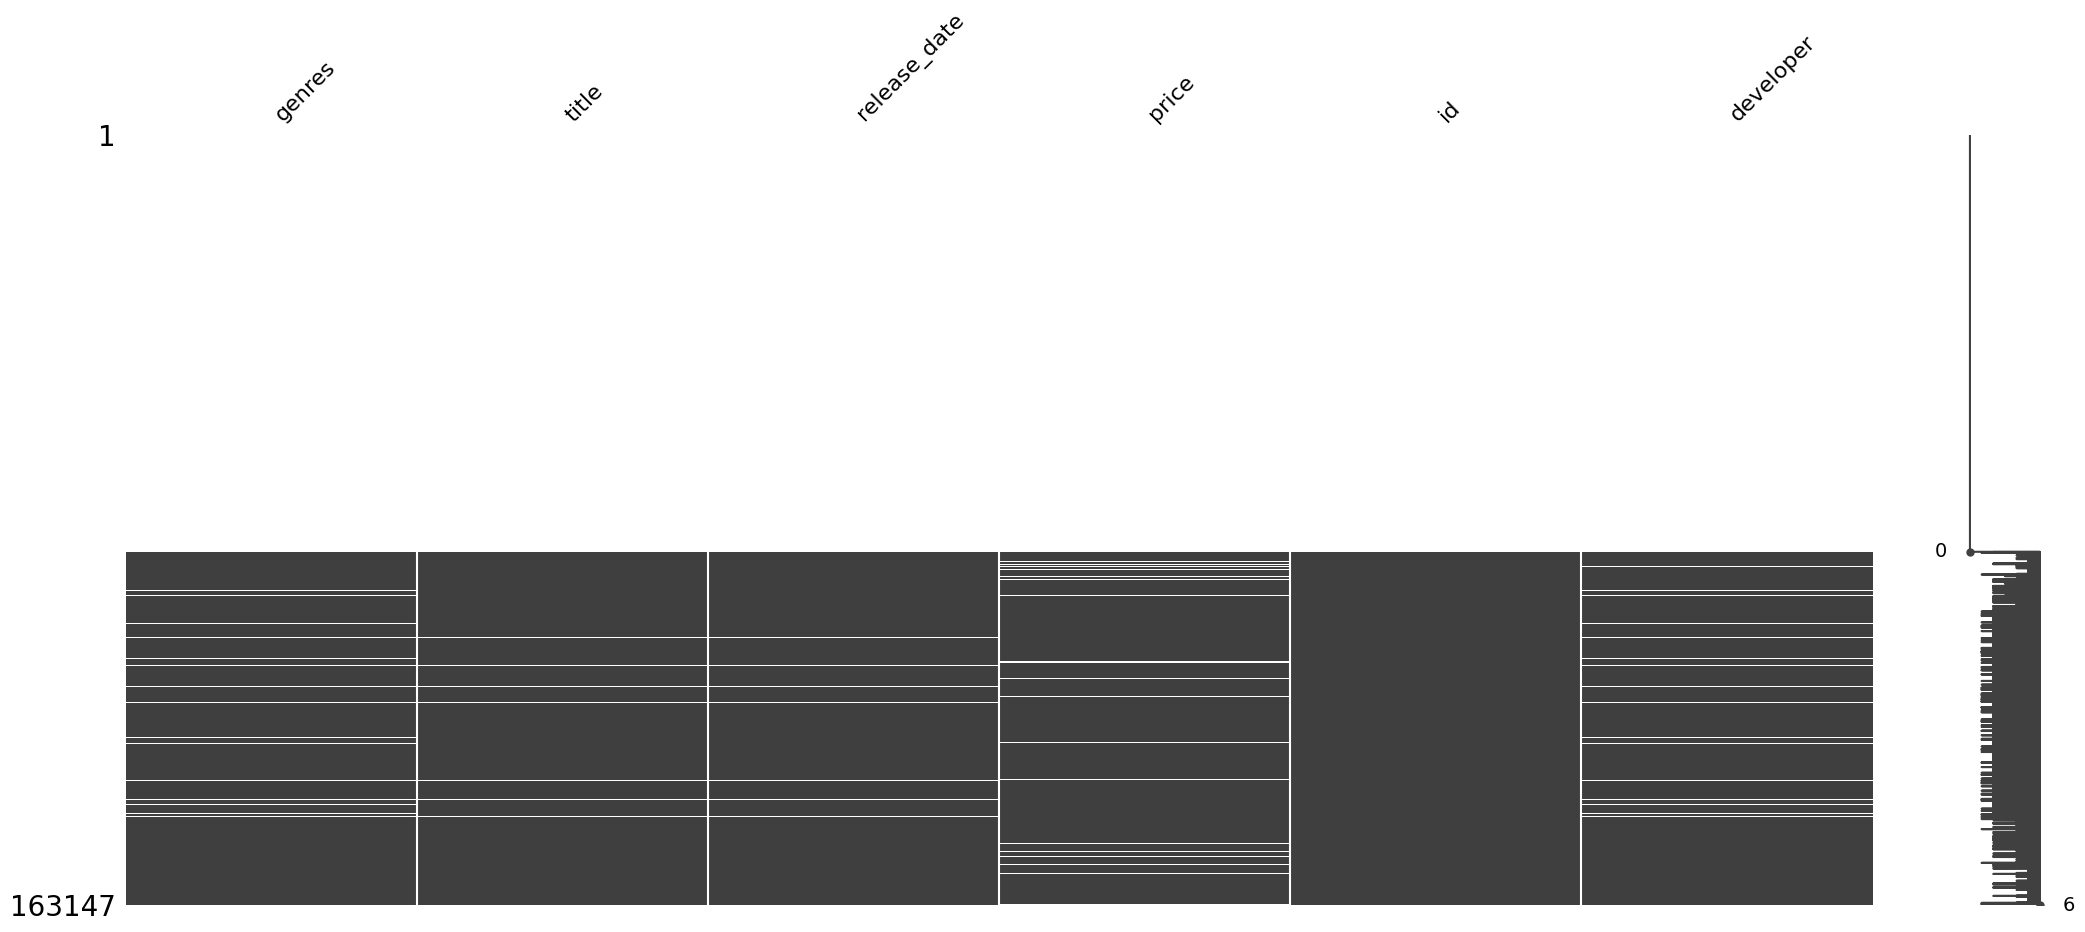

In [11]:
#Se eliminan las columnas que no son relevantes para ninguno de los enpoints.
games_1.drop(columns=['publisher','app_name','url','tags','reviews_url','specs','early_access'],inplace=True)
#La columna genres tiene una lista de elementos. Para desanidar esa columna, se utiliza el método explode.
games = games_1.explode('genres')
#Usamos el método matrix de missingno para graficar una matriz que permite objervar la distribución de los valores faltantes. 
msno.matrix(games)

Axes(0.125,0.11;0.698618x0.77)
<class 'pandas.core.frame.DataFrame'>
Index: 74832 entries, 88311 to 120444
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        71549 non-null  object 
 1   title         72781 non-null  object 
 2   release_date  72730 non-null  object 
 3   price         71486 non-null  object 
 4   id            74829 non-null  float64
 5   developer     71353 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.0+ MB
Información general None
Conteo de valores genres          71549
title           72781
release_date    72730
price           71486
id              74829
developer       71353
dtype: int64
Conteo de nulos genres          3283
title           2051
release_date    2102
price           3346
id                 3
developer       3479
dtype: int64


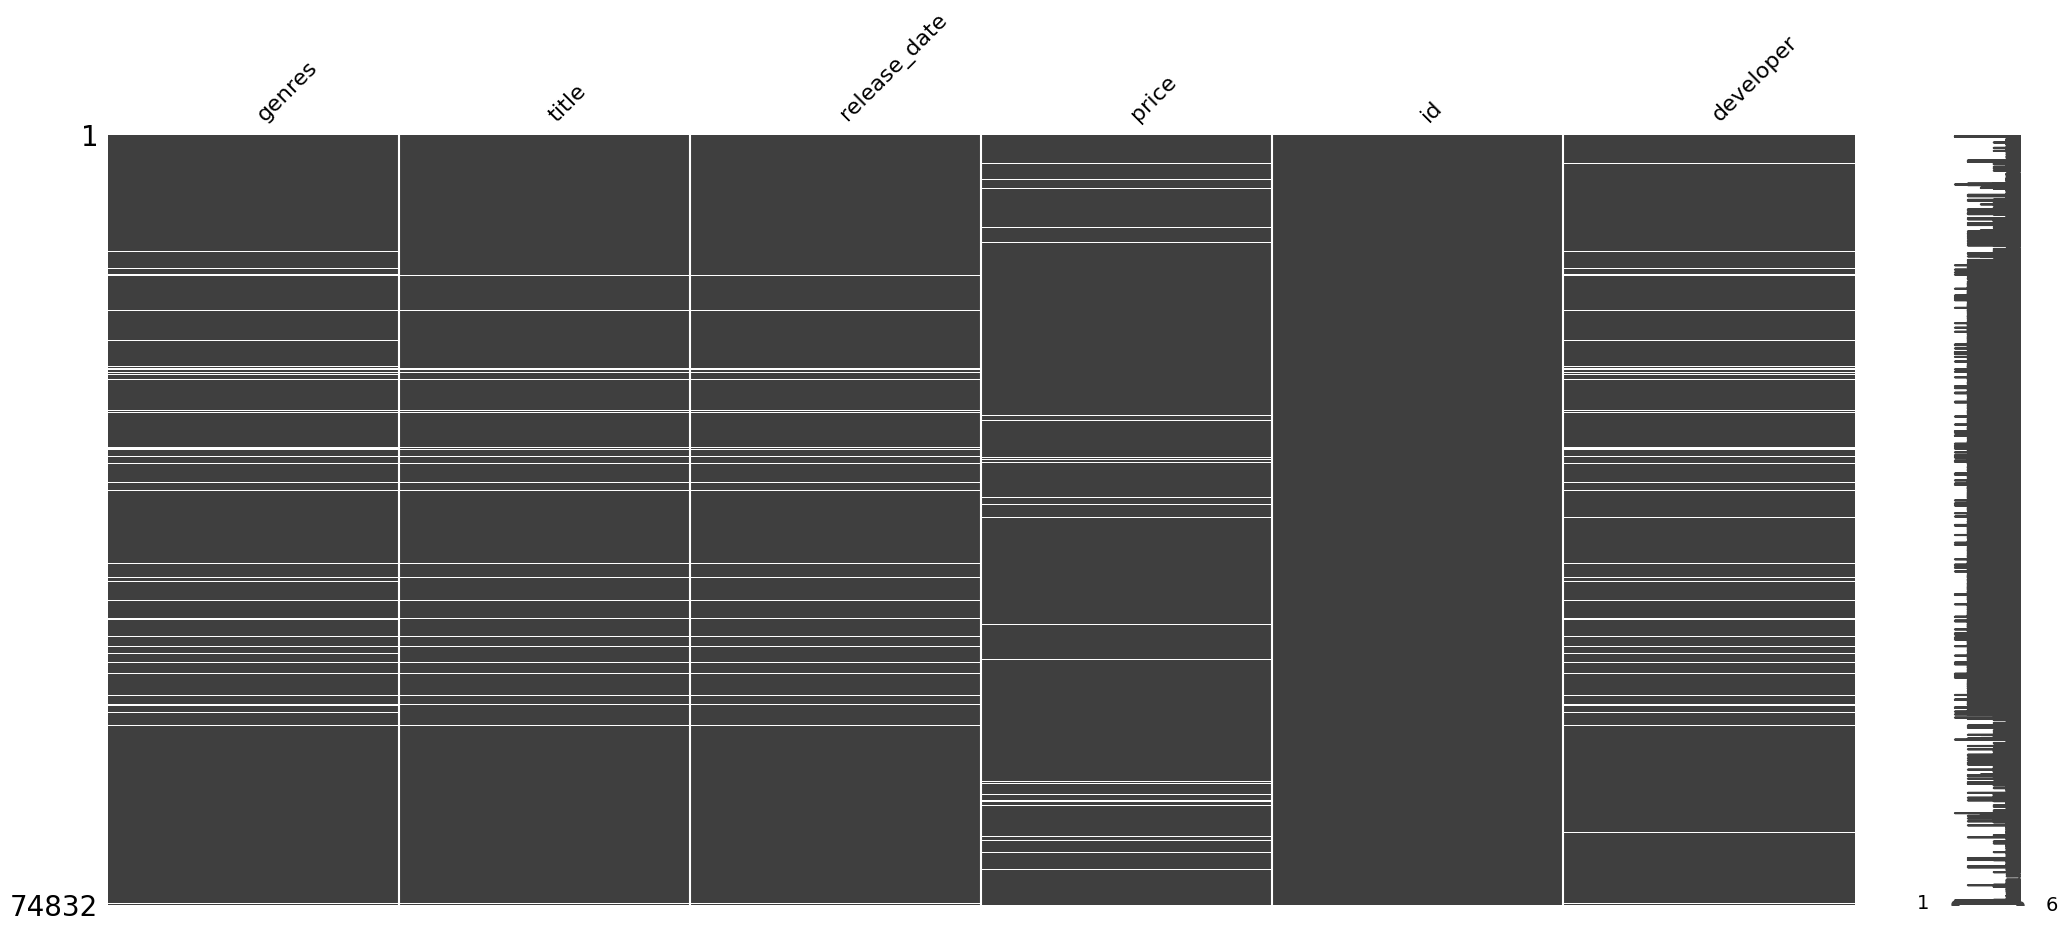

In [12]:
#La matriz nos muestra que que los primeros datos se encuentran vacios. Al hacer una exploración de archivo en crudo, encontramos que los datos empiezan en el valor numero 88311. Por eso eliminamos todos los indices antes que este.
games=games.drop(range(0,88311),axis=0)

#Tras hacer esta primera limpieza, hacemos un conteo de los valores totales y los nulos.
print(msno.matrix(games))
print('Información general',games.info())
print('Conteo de valores',games.count())
print('Conteo de nulos',games.isna().sum())

In [13]:
#Se borran los valores nulos para las columnas que tienen pocos valores nulos.
games.dropna(subset=['id'], inplace=True)
games.dropna(subset=['price'], inplace=True)
#Se imputa la categoría Missing a los valores nulos de las otras columnas.
games['developer'].fillna('Missing', inplace=True)
games['title'].fillna('Missing', inplace=True)
games['genres'].fillna('Missing', inplace=True)
games['release_date'].fillna('Missing', inplace=True)

/var/folders/0p/l9p40s5527102cq821lz6jlw0000gn/T/ipykernel_1059/1305238497.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games['developer'].fillna('Missing', inplace=True)
/var/folders/0p/l9p40s5527102cq821lz6jlw0000gn/T/ipykernel_1059/1305238497.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [14]:
#Se identifican y eliminan los valores duplicados
all_duplicates = games[games.duplicated(subset=['id'], keep=False)]
print(all_duplicates)
games = games.drop_duplicates(subset=['id'])

              genres                    title release_date         price  \
88311   Free to Play                Ironbound   2018-01-04  Free To Play   
88311          Indie                Ironbound   2018-01-04  Free To Play   
88311            RPG                Ironbound   2018-01-04  Free To Play   
88311       Strategy                Ironbound   2018-01-04  Free To Play   
88312         Casual  Real Pool 3D - Poolians   2017-07-24  Free to Play   
...              ...                      ...          ...           ...   
120442         Indie            Russian Roads   2018-01-04          1.99   
120442        Racing            Russian Roads   2018-01-04          1.99   
120442    Simulation            Russian Roads   2018-01-04          1.99   
120443        Casual      EXIT 2 - Directions   2017-09-02          4.99   
120443         Indie      EXIT 2 - Directions   2017-09-02          4.99   

              id                 developer  
88311   643980.0          Secret Level SRL

In [15]:
# Se identifican los valores únicos en la columna price
print(games['price'].unique())

['Free To Play' 'Free to Play' 0.99 2.99 3.99 9.99 18.99 29.99 'Free'
 10.99 1.5899999999999999 14.99 1.99 59.99 4.99 8.99 6.99 7.99 39.99 19.99
 7.49 12.99 5.99 2.49 15.99 1.25 24.99 17.99 61.99 3.49 11.99 13.99
 'Free Demo' 'Play for Free!' 34.99 74.76 1.49 32.99 99.99 14.95 69.99
 16.99 79.99 49.99 5.0 44.99 13.98 29.96 119.99 109.99 149.99 771.71
 'Install Now' 21.99 89.99 'Play WARMACHINE: Tactics Demo' 0.98 139.92
 4.29 64.99 'Free Mod' 54.99 74.99 'Install Theme' 0.89 'Third-party' 0.5
 'Play Now' 299.99 1.29 3.0 15.0 5.49 23.99 49.0 20.99 10.93
 1.3900000000000001 'Free HITMAN™ Holiday Pack' 36.99 4.49 2.0 4.0 9.0
 234.99 1.9500000000000002 1.5 199.0 189.0 6.66 27.99 10.49 129.99 179.0
 26.99 399.99 31.99 399.0 20.0 40.0 3.33 199.99 22.99 320.0 38.85 71.7
 59.95 995.0 27.49 3.39 6.0 19.95 499.99 16.06 4.68 131.4 44.98 202.76 1.0
 2.3 0.9500000000000001 172.24 249.99 2.9699999999999998 10.96 10.0 30.0
 2.66 6.48 19.29 11.15 18.9 2.89 'Play the Demo' 99.0 87.94 599.0 8.98
 9.69 0

In [16]:
#Se imputa el valor de 0 para los strings en que se dice que el precio es gratuito. 
games['price'] = games['price'].replace(['Free To Play', 'Free to Play', 'Free', 'Play for Free!', 'Free Demo', 'Install Now', 'Free Mod', 'Install Theme', 'Play Now', 'Free HITMAN™ Holiday Pack', 'Free Movie', 'Free to Try', 'Free to Use','Play WARMACHINE: Tactics Demo', 'Play the Demo','Third-party'], 0)
#Se imputa el valor de 449 para los strings en que se dice que ese es el precio
games['price'] = games['price'].replace(['Starting at $449.00'], 449.00)
#Se imputa el valor de 499 para los strings en que se dice que ese es el precio
games['price'] = games['price'].replace(['Starting at $499.00'], 499.00)

/var/folders/0p/l9p40s5527102cq821lz6jlw0000gn/T/ipykernel_1059/3000313505.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  games['price'] = games['price'].replace(['Starting at $499.00'], 499.00)


In [17]:
#Se revisa el tipo de dato de cada columna
print(games.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30754 entries, 88311 to 120444
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        30754 non-null  object 
 1   title         30754 non-null  object 
 2   release_date  30754 non-null  object 
 3   price         30754 non-null  float64
 4   id            30754 non-null  float64
 5   developer     30754 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.6+ MB
None


In [18]:
#Se transforma a tipo numérico la columna price
games['price'] = pd.to_numeric(games['price'], errors='coerce')
#Se transforma a tipo datetime la columna release_date
games['release_date'] = pd.to_datetime(games['release_date'],errors='coerce')
#Se crea una columna que solo contiene el año partiendo de la columna release_date
games['release_year'] = games['release_date'].dt.year
#Se transforma a tipo numerico la columna id
games['id']=games['id'].astype(int)

In [19]:
#Imprimimos información general del dataframe para confirmar que sea la deseada. Confirmamos que tiene un total de 30754 valores.
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30754 entries, 88311 to 120444
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   genres        30754 non-null  object        
 1   title         30754 non-null  object        
 2   release_date  28779 non-null  datetime64[ns]
 3   price         30754 non-null  float64       
 4   id            30754 non-null  int64         
 5   developer     30754 non-null  object        
 6   release_year  28779 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.9+ MB


Reviews

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    59305 non-null  object
 1   recommend  59305 non-null  object
 2   review     59305 non-null  object
 3   user_id    59333 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
Información general None
Conteo de valores item_id      59305
recommend    59305
review       59305
user_id      59333
dtype: int64
Conteo de nulos item_id      28
recommend    28
review       28
user_id       0
dtype: int64


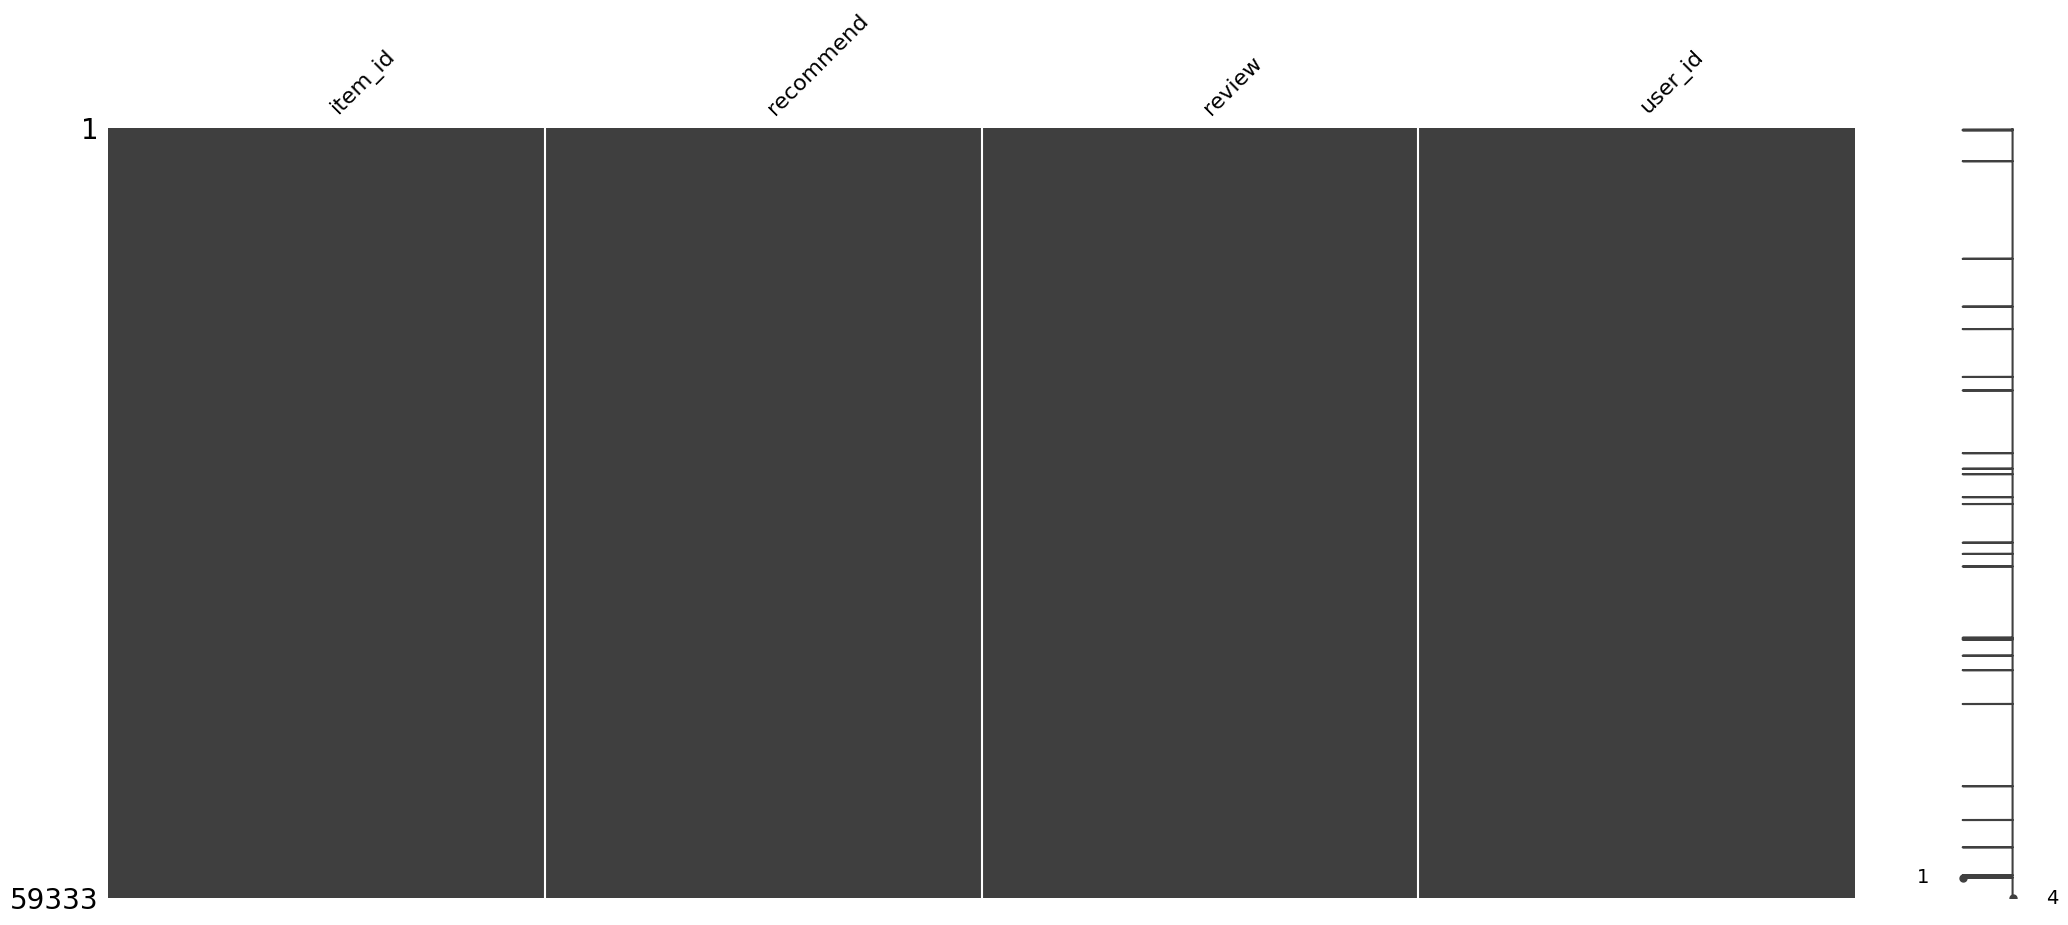

In [20]:
#Se eliminan las columnas que no son relevantes para ninguno de los enpoints.
reviews.drop(columns=['funny','helpful','posted','last_edited'],inplace=True)
#Usamos el método matrix de missingno para graficar una matriz que permite objervar la distribución de los valores faltantes.
msno.matrix(reviews)
#Hacemos un conteo de los valores totales y los nulos.
print('Información general',reviews.info())
print('Conteo de valores',reviews.count())
print('Conteo de nulos',reviews.isna().sum())

In [21]:
#Se identifican y eliminan los valores duplicados
all_duplicates = reviews[reviews.duplicated(keep=False)]
print(all_duplicates)
reviews.dropna(inplace=True)

      item_id recommend                                             review  \
31     252950      True                                            love it   
115    298630      True                                       Its so bosss   
280    346110      True  It's a good game, mechanics seem solid and the...   
281    380770     False  Well, I don't have much to say about the game....   
282    454890      True  It's a pretty good game, not bad for the 49 ce...   
...       ...       ...                                                ...   
44456  422400      True  Muy entretenido y una coleccion de armas prome...   
44457  218620      True  Tiene una jugabilidad y tematica muy buena :D,...   
44458  261820      True  Buen juego, no importa el desarrrollo que tien...   
44459  224260      True  exelente aporte :D¡¡¡ es una buen mod basado e...   
44603     730      True                10/10 too many children with mikes.   

                    user_id  
31        76561198156664158  
115

In [22]:
#Chequeo de tipos de dato y transformación de estos 
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 59332
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    59305 non-null  object
 1   recommend  59305 non-null  object
 2   review     59305 non-null  object
 3   user_id    59305 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


In [23]:
#Se transforma a tipo numérico la columna item_id
reviews['item_id'] = pd.to_numeric(reviews['item_id'], errors='coerce')
#Se transforma a tipo booleano la columna recommend
reviews['recommend']=reviews['recommend'].astype(bool)

In [24]:

reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 59332
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    59305 non-null  int64 
 1   recommend  59305 non-null  bool  
 2   review     59305 non-null  object
 3   user_id    59305 non-null  object
dtypes: bool(1), int64(1), object(2)
memory usage: 1.9+ MB


Feature engineering para Reviews

In [25]:
#Para facilitar el procesamiento de los datos se va a utilizar el modelo VADER.
#Se instancia el modelo de SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
#Se crea una función que aplica el análisis de sentimiento y le asigna un valor (0,1,2 o Negativo, Neutral y Positivo) segun la puntuación que tenga en el analysis.
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 2  # Positiva
    elif compound_score <= -0.05:
        return 0  # Negativa
    else:
        return 1  # Neutral
#Se aplica la función a la columna review para crear la columna sentiment.
reviews['sentiment'] = reviews['review'].apply(analyze_sentiment)

Items

In [26]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   item_name         object 
 2   playtime_forever  float64
 3   playtime_2weeks   float64
 4   user_id           object 
 5   items_count       int64  
 6   steam_id          object 
dtypes: float64(2), int64(1), object(4)
memory usage: 276.1+ MB


Axes(0.125,0.11;0.698618x0.77)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   item_name         object 
 2   playtime_forever  float64
 3   user_id           object 
 4   items_count       int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 197.2+ MB
Información general None
Conteo de valores item_id             5153209
item_name           5153209
playtime_forever    5153209
user_id             5170015
items_count         5170015
dtype: int64
Conteo de nulos item_id             16806
item_name           16806
playtime_forever    16806
user_id                 0
items_count             0
dtype: int64


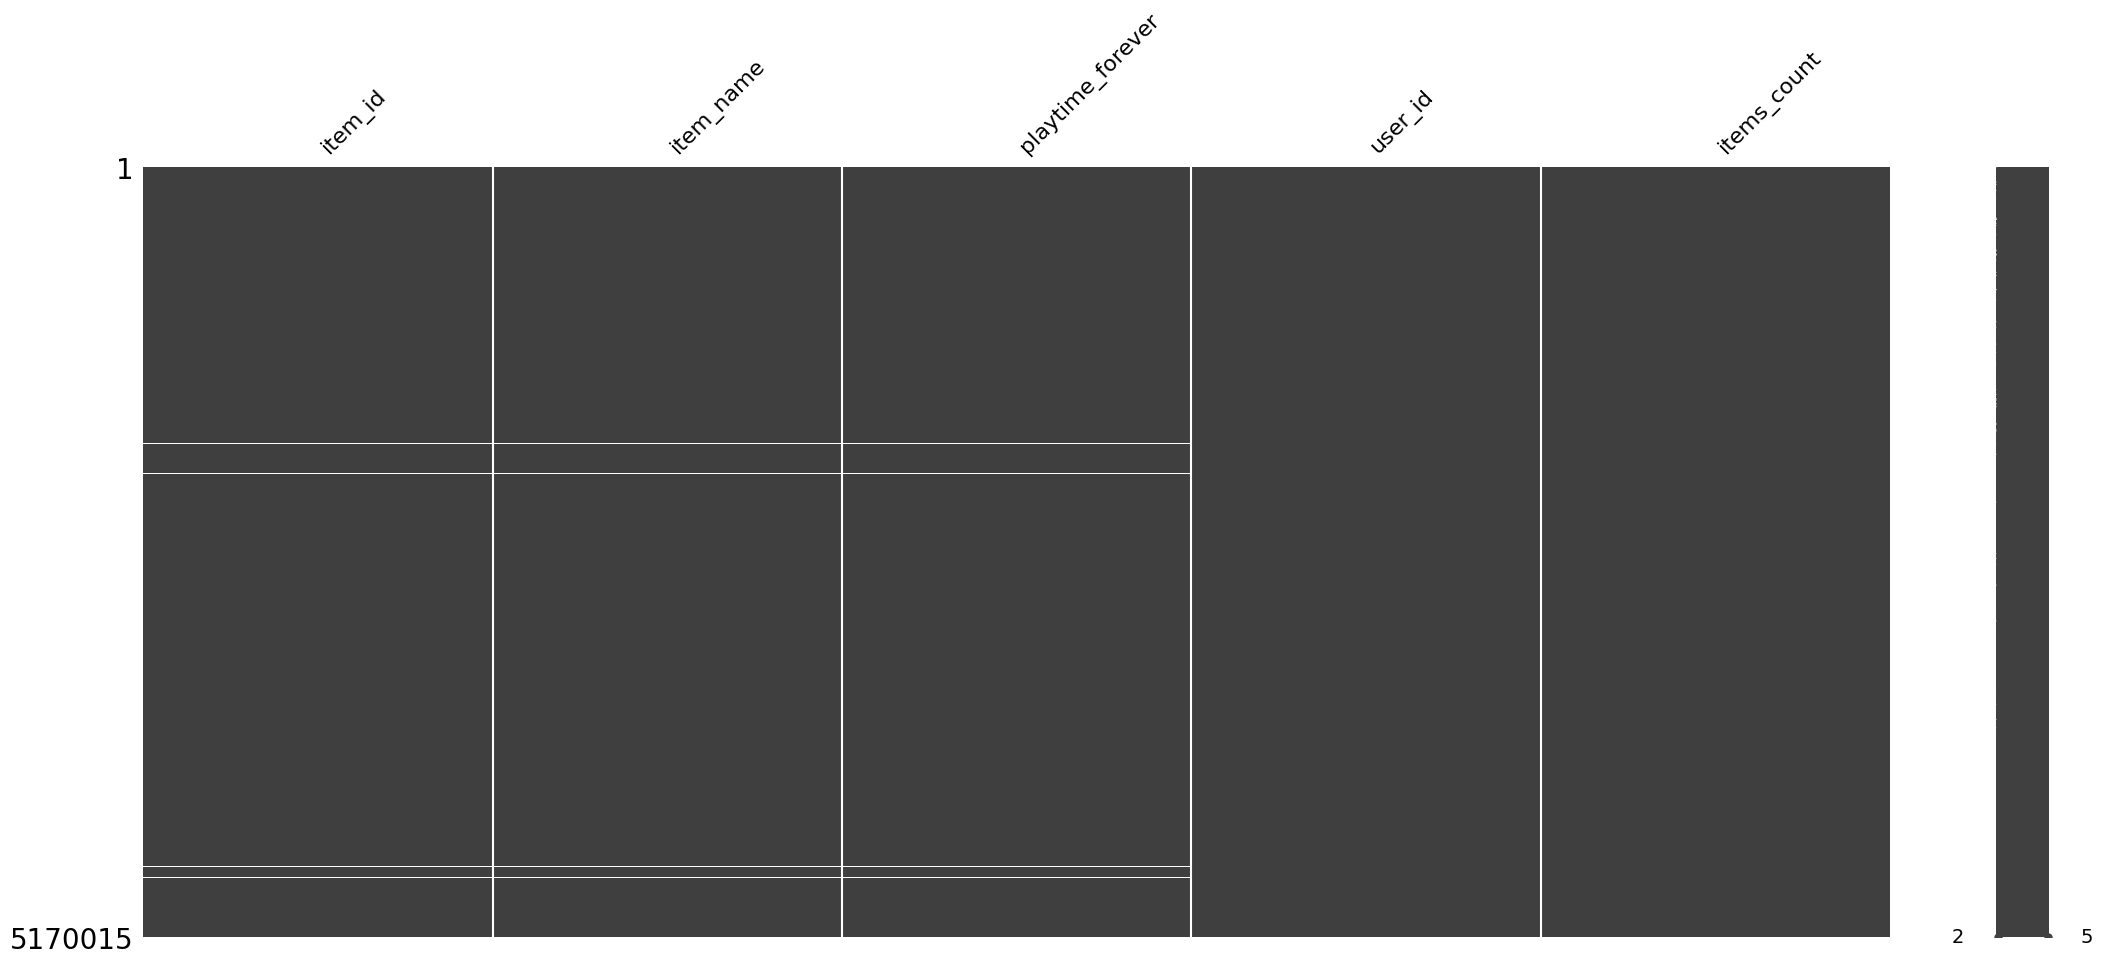

In [27]:
#Se eliminan las columnas que no son relevantes para ninguno de los enpoints.
items.drop(columns=['playtime_2weeks','steam_id'],inplace=True)
#Hacemos un conteo de los valores totales y los nulos.
print(msno.matrix(items))
print('Información general',items.info())
print('Conteo de valores',items.count())
print('Conteo de nulos',items.isna().sum())

In [28]:
#Se identifican y eliminan los valores duplicados
all_duplicates = items[items.duplicated(keep=False)]
print(all_duplicates)
items = items.drop_duplicates()

        item_id                                    item_name  \
4346       4000                                  Garry's Mod   
4347      33910                                       Arma 2   
4348      33930                  Arma 2: Operation Arrowhead   
4349     219540  Arma 2: Operation Arrowhead Beta (Obsolete)   
4350        400                                       Portal   
...         ...                                          ...   
4910940  261030                 The Walking Dead: Season Two   
4910941  273110                Counter-Strike Nexon: Zombies   
4910942     730             Counter-Strike: Global Offensive   
4985582     NaN                                          NaN   
4985583     NaN                                          NaN   

         playtime_forever            user_id  items_count  
4346                269.0  76561198156664158           59  
4347                162.0  76561198156664158           59  
4348                223.0  76561198156664158       

In [29]:
#Chequeo de tipos de dato y transformación de estos 
items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110806 entries, 0 to 5170014
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   item_name         object 
 2   playtime_forever  float64
 3   user_id           object 
 4   items_count       int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 234.0+ MB


In [30]:
#Se transforma a tipo numérico la columna item_id
items['item_id'] = pd.to_numeric(items['item_id'], errors='coerce')

Load
Se separa un dataframe por cada endpoint

In [31]:
#Endpoint1
#Se seleccionan las columnas que se van a utilizar
endpoint1= games[['developer','release_year','id','price']] 
#Se filtran los valores donde el desarrollador es Missing porque estos valores son irrelevantes para este endpoint
endpoint1_limpio=endpoint1[endpoint1['developer']!='Missing']
#Se extrae una puestra del 30% del total de los valores
endpoint1_sample=endpoint1_limpio.sample(frac=0.3,random_state=1) 
#Se exporta a un parquet
endpoint1_sample.to_parquet('endpoint1',engine='pyarrow') 
print(endpoint1_sample.tail())


                         developer  release_year      id  price
89222               Dovetail Games        2012.0   65252   8.99
107786  KOEI TECMO GAMES CO., LTD.        2017.0  521650  12.99
104836                FunnerFlight        2017.0  614005  24.99
108229            Antoine Bilodeau        2016.0  516120   2.99
104741                Jack Gloyens        2017.0  663540   4.99


In [32]:
#Endpoint2
#Se combinan los Data Frames items y reviews
Merge_1=pd.merge(items,reviews,how='inner',on='user_id')
#Se combina el Data Frame anterior con games
Merged=pd.merge(Merge_1,games,how='left',left_on='item_name',right_on='title')
#Se seleccionan las columnas que se van a utilizar
endpoint2=Merged[['user_id','item_id_x','price','recommend','items_count']]
#Se extrae una puestra del 30% del total de los valores
endpoint2_sample=endpoint2.sample(frac=0.3,random_state=1)
#Se exporta a un parquet
endpoint2_sample.to_parquet('endpoint2',engine='pyarrow')

In [33]:
#Se combinan los Data Frames items y games
endpoint3 = pd.merge(items, games, how='left', left_on='item_id', right_on='id')
#Se filtran los valores donde el genero es Missing porque estos valores son irrelevantes para este endpoint
endpoint3_limpio=endpoint3[endpoint3['genres']!='Missing']
#Se seleccionan las columnas que se van a utilizar
endpoint3 = endpoint3_limpio[['genres', 'user_id', 'id', 'playtime_forever', 'release_year']]
#Se extrae una puestra del 10% del total de los valores
endpoint3_sample = endpoint3.sample(frac=0.1, random_state=1)
#Se exporta a un parquet
endpoint3_sample.to_parquet('endpoint3', engine='pyarrow')

In [34]:
endpoint3_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502427 entries, 4328355 to 4084723
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genres            407569 non-null  object 
 1   user_id           502427 non-null  object 
 2   id                407569 non-null  float64
 3   playtime_forever  500774 non-null  float64
 4   release_year      404588 non-null  float64
dtypes: float64(3), object(2)
memory usage: 23.0+ MB


In [35]:
#Endpoint4
#Se combinan los Data Frames reviews y games
endpoint4= pd.merge(reviews,games,how='left',left_on='item_id',right_on='id')
#Se filtran los valores donde el desarrollador es Missing porque estos valores son irrelevantes para este endpoint
endpoint4_limpio=endpoint4[endpoint4['developer']!='Missing']
#Se seleccionan las columnas que se van a utilizar
endpoint4=endpoint4_limpio[['release_year','developer','user_id','recommend','sentiment']]
#Se extrae una puestra del 30% del total de los valores
endpoint4_sample=endpoint4.sample(frac=0.3,random_state=1)
#Se exporta a un parquet
endpoint4_sample.to_parquet('endpoint4',engine='pyarrow')

In [36]:
#Endpoint5
#Se combinan los Data Frames reviews y games
endpoint5=pd.merge(reviews,games,how='left',left_on='item_id',right_on='id')
#Se filtran los valores donde el desarrollador es Missing porque estos valores son irrelevantes para este endpoint
endpoint5_limpio=endpoint5[endpoint5['developer']!='Missing']
#Se seleccionan las columnas que se van a utilizar
endpoint5=endpoint5_limpio[['user_id','developer','sentiment']]
#Se extrae una puestra del 30% del total de los valores
endpoint5_sample=endpoint5.sample(frac=0.3,random_state=1)
#Se exporta a un parquet
endpoint5_sample.to_parquet('endpoint5',engine='pyarrow')

MACHINE LEARNING

In [37]:
#Se combinan los Data Frames reviews e items
merged = pd.merge(reviews[['user_id', 'sentiment']], items[['user_id', 'item_name']], on='user_id')
#Se eliminan los duplicados
df_model = merged.drop_duplicates()
#Se extrae una puestra del 30% del total de los valores
df_model_sample = df_model.sample(frac=0.3, random_state=1)
#Se exporta a un parquet
df_model_sample.to_parquet('df_Modelo', engine='pyarrow')
